# Кластерный анализ неоднородных данных

## Цели

Имея неклассифицированную обучающую выборку с помощью кластерного анализа и других алгоритмов классифицировать многомерные неоднородные данные.

## Постановка задачи

Для данных Фишера:

1) Провести предварительный анализ кластерной структуры в данных;

2) Провести кластерный анализ данных;

3) При помощи других алгоритмов классификации с неклассифицироанной обучающей выборки классифицировать данные;

4) Провести сравнительный анализ полученных результатов.

*Указание*: использовать неклассифицированную выборку из смеси распределений для всех переменных; использовать алгоритмы: К-средних и иерархический кластерный анализ.

# Результаты исследований

## Подключение необходимых библиотек и загрузка данных

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [62]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import random

from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import norm, skew, kurtosis, shapiro, chisquare, gaussian_kde, kstest, ttest_ind, spearmanr
from statistics import correlation
import statsmodels.api as sm
from statsmodels.formula.api import ols

В задаче кластеризации с неклассифицированной выборкой у нас имеется лишь набор объектов и их признаков. Сколько кластер и какие объекты к какмоу кластеру относятся --- нам неизвестно.

In [10]:
dataset = datasets.load_iris()

ext_target = dataset.target[:, None]
df = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=dataset.feature_names + ['target label', 'target name'])
df = pd.concat([df.loc[df['target name'] == 'versicolor'], df.loc[df['target name'] == 'virginica']], axis=0)[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target label']].astype(float)
X = df.iloc[:, :4]
y = df.iloc[:, 4]
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Предварительный анализ

Рассмотрим матрицу диаграмм рассеяния для выявления наличия кластерной структуры.

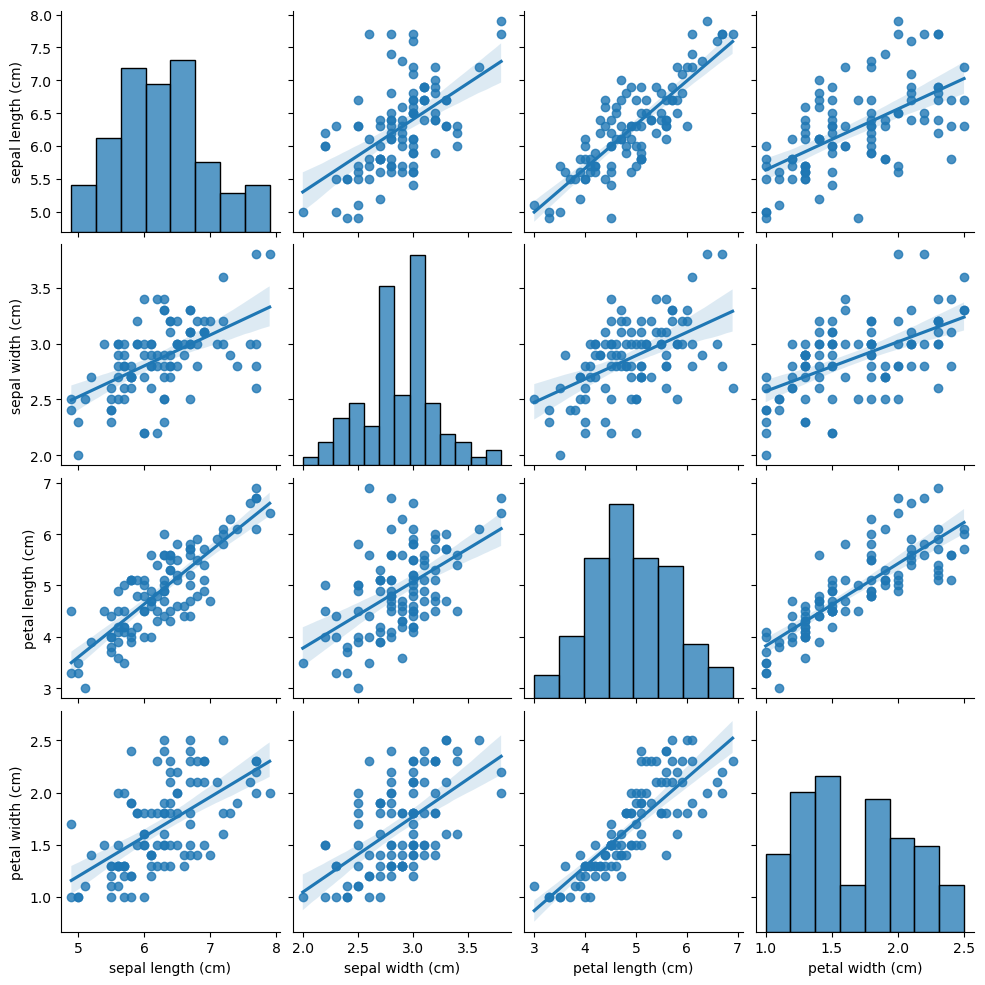

In [11]:
sns.pairplot(data=X, kind='reg', diag_kind='auto')
None

Из построенной матрицы мы не можем сделать никаких выводов. Если в выборке и имеется кластерная структура, то явно проследнить ее нельзя, так как если кластеры есть, то они не имеют четкой разделимости.

## Применение алгоритмов кластеризации в задаче обучения с неклассифицированной выборкой

### Алгоритм К средних

Для определения количества кластеров воспользуемся IS-индексом.

For n_clusters = 2 The average silhouette_score is : 0.4404519800077125
For n_clusters = 3 The average silhouette_score is : 0.36610589354355655
For n_clusters = 4 The average silhouette_score is : 0.35797317624424096
For n_clusters = 5 The average silhouette_score is : 0.2783065885903804
For n_clusters = 6 The average silhouette_score is : 0.3231091975639186


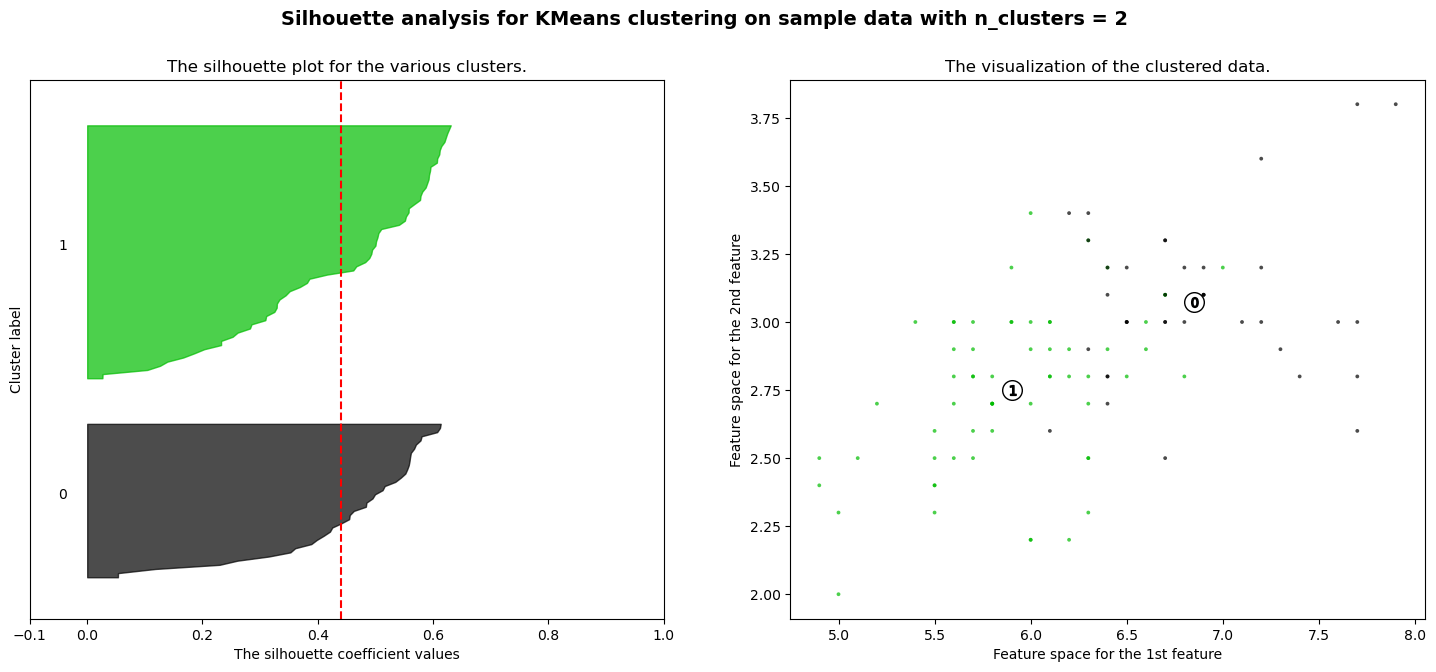

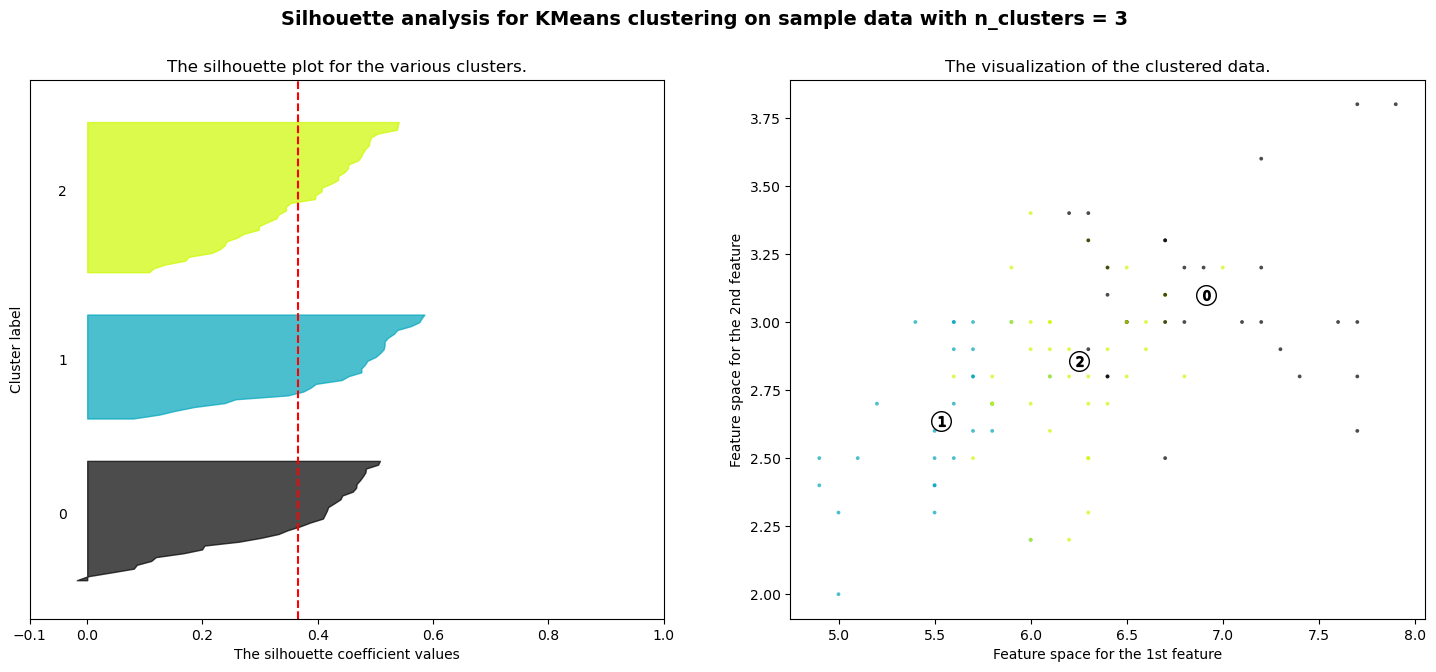

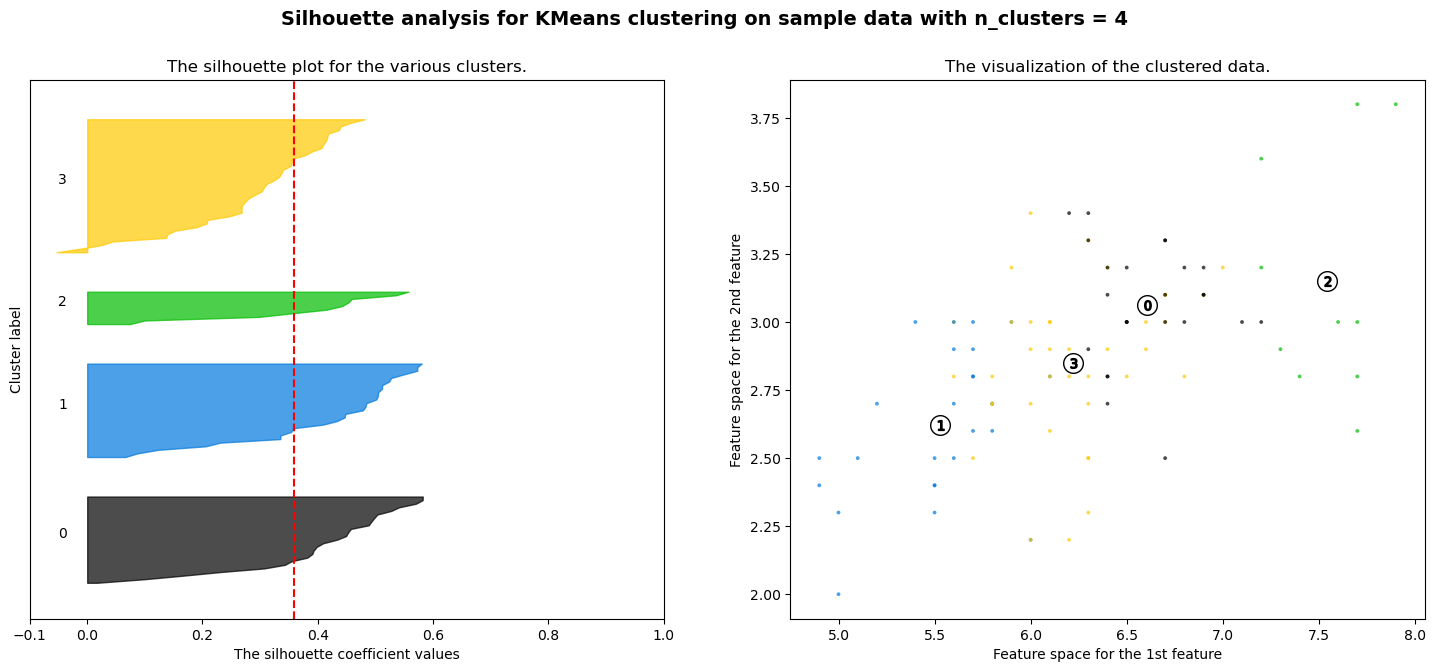

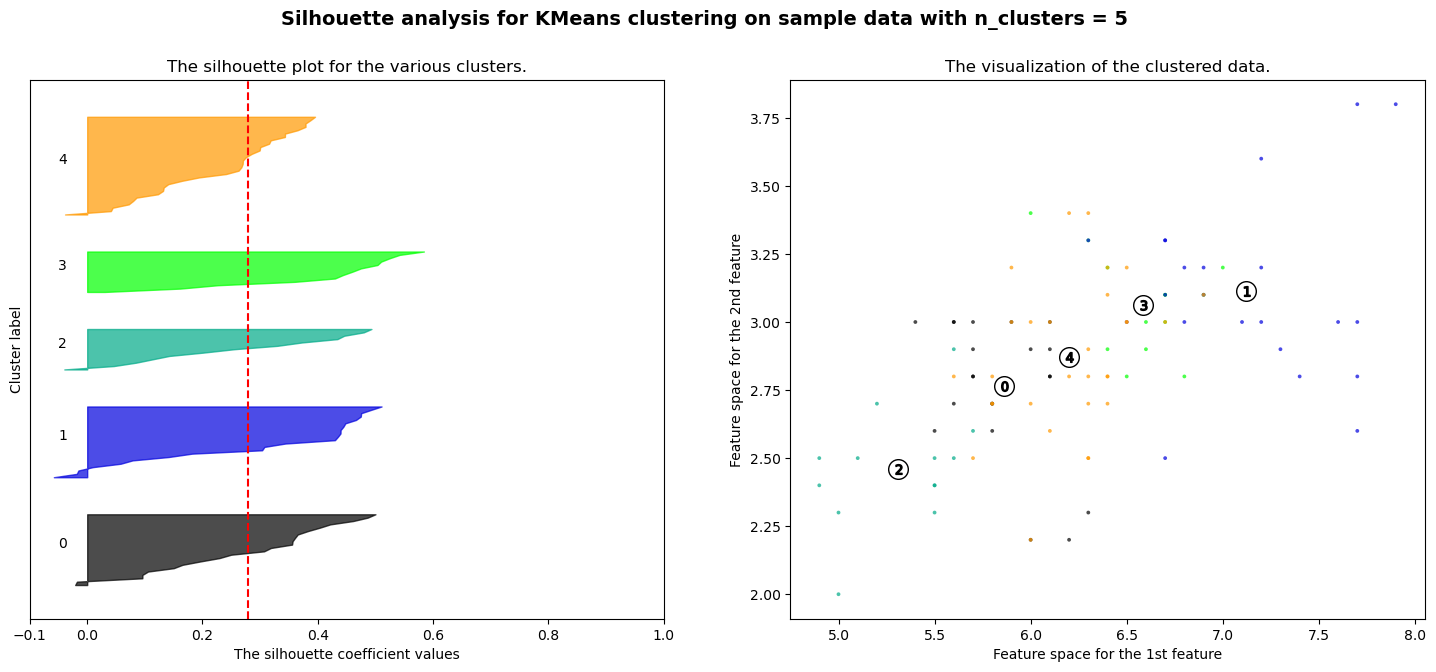

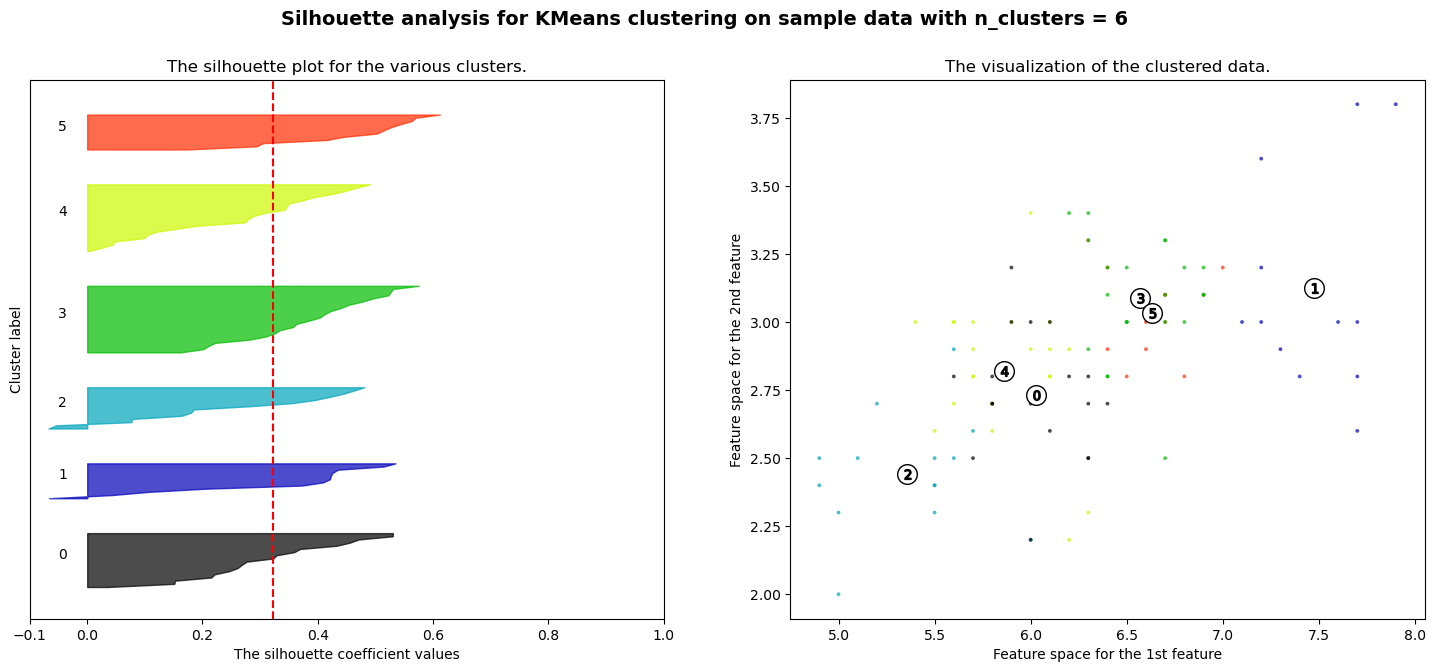

In [31]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto")
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Только в самом первом случае, когда предполагается, что 2 кластера, значение коэффициента силуэта для каждого кластера больше 0.6. Поэтому можем предполагать, что у нас имеется 2 кластера.

Сравним также СН-индексы для того, чтобы убедиться в том, что выборке можно разделить на 2 кластера.

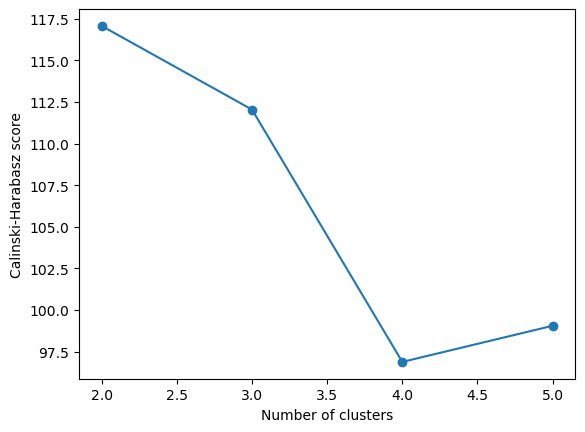

In [28]:
score = []

for i in range(2,6):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(X)
    score.append(calinski_harabasz_score(X, kmeans.labels_))

plt.plot(range(2,6), score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

СН-индекс достигает наибольшего значения при 2 кластерах, поэтому считаем такое предположение верным. Построим графики центров кластеров.

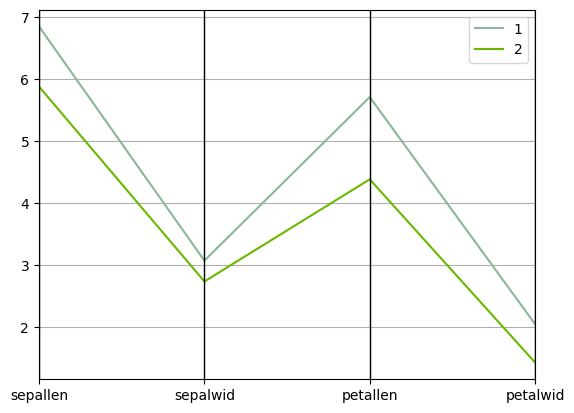

In [57]:
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(X)
centers = kmeans.cluster_centers_
centers = pd.DataFrame(centers, columns=['sepallen', 'sepalwid', 'petallen', 'petalwid'])
centers['label'] = pd.Series([1, 2, 3])
pd.plotting.parallel_coordinates(centers, 'label')
None

Графики не пересекают друг друга, следовательно, можем сделать вывод, что все переменные оказались значимыми при классификации.

Вычислим точность предсказаний модели.

In [58]:
sum(kmeans.labels_==y) / y.size

0.47

То есть пости 50% объектов модель смогла классифицировать верно.

Вывод: модель К средних смогла успешно выделить 2 кластера в случайной выборке. Выборка действительно состоит из двух кластеров, поэтому такое предсказание является верным.

### Иерархический кластерный анализ

Снова воспользуемся СН-индексом для определения наилучшего числа кластеров.

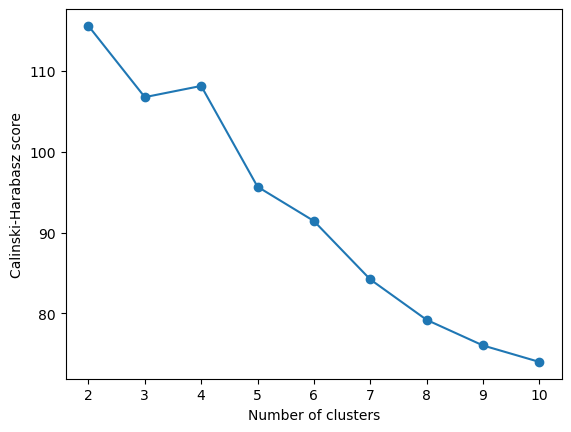

In [66]:
score = []

for i in range(2,11):
    clf = AgglomerativeClustering(n_clusters=i, metric='euclidean')
    clf.fit(X)
    score.append(calinski_harabasz_score(X, clf.labels_))

plt.plot(range(2,11), score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

Из графика видно, что наибольшее значение СН-индекса при числе кластеров равном 2. Подкрепим это предположение, построив дендрограмму и график расстояний между кластерами.

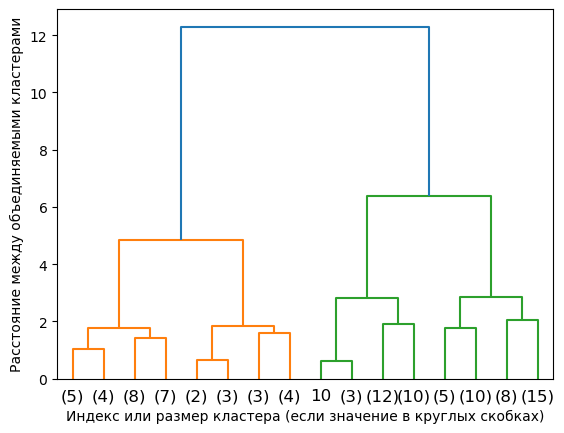

In [64]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Индекс или размер кластера (если значение в круглых скобках)")
plt.ylabel('Расстояние между объединяемыми кластерами')
plt.show()

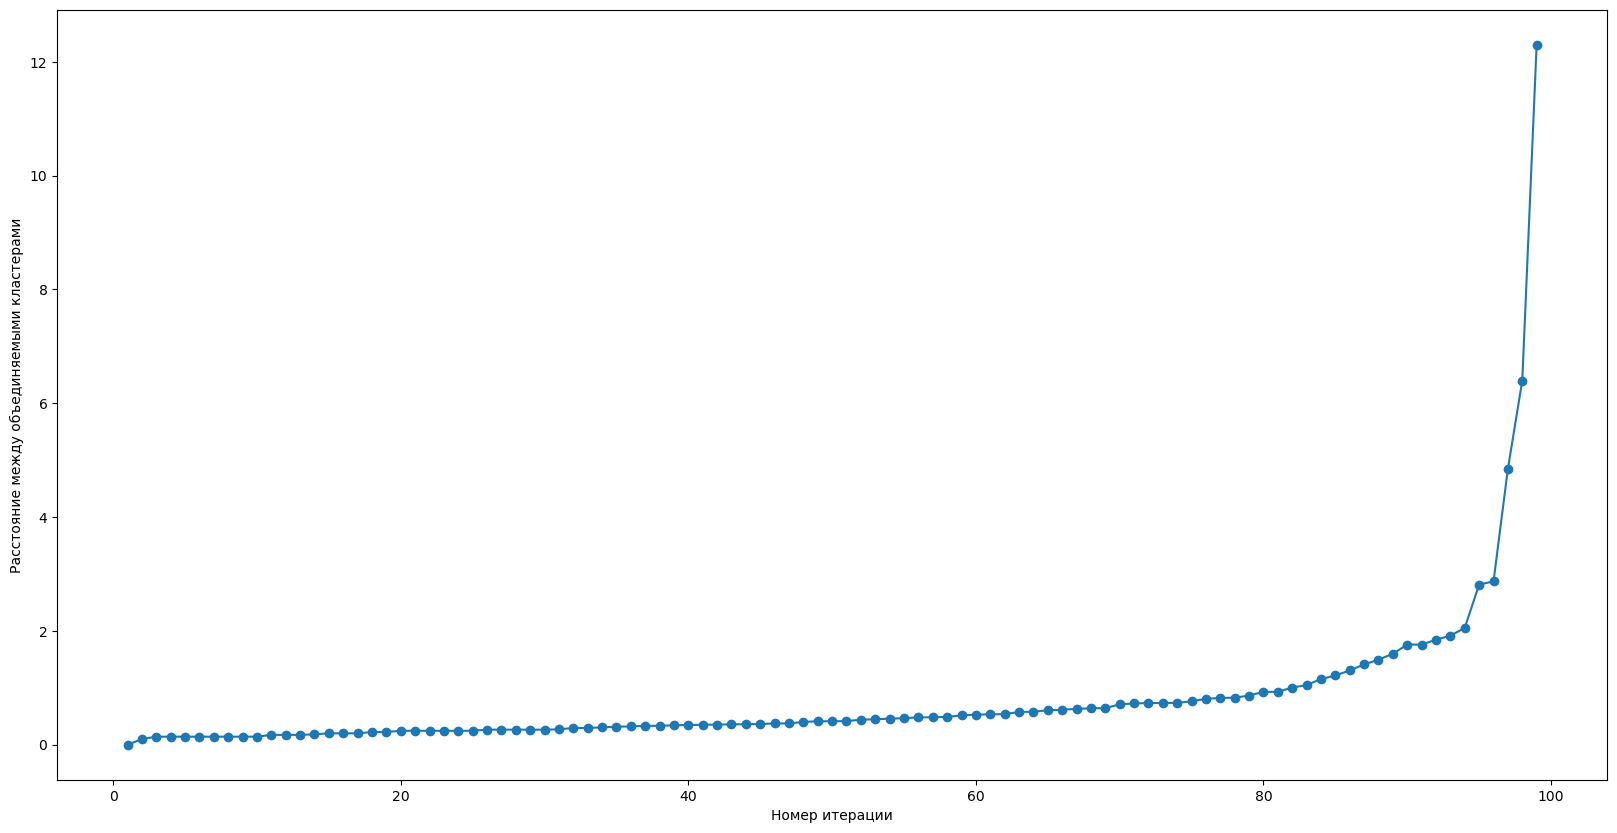

In [65]:
clf = AgglomerativeClustering(n_clusters=2, compute_distances=True)
plt.figure(figsize=(20, 10))
plt.plot(range(1, len(X)), clf.fit(X).distances_, marker='o')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние между объединяемыми кластерами')
plt.show()

Отсюда можем также утверждать, что число кластеров равно 2. Второй график резко уходит вверх примерно на значениях тех значениях, которые соответствуют двум кластерам в первом графике.

Вычислим точность классификации.

In [67]:
clf = AgglomerativeClustering(n_clusters=3)
clf.fit(X)
sum(clf.labels_==y) / y.size

0.25

Отсюда следует, что мы смогли предсказать 25% значений класса верно для нашей выборки.

Вывод: иерархический кластерный анализ также смог разделить выборку на 2 кластера что является верным решением. Однако с задачей классификации объектов он справился хуже, чем метод К средних.

Таким образом, мы можем принять предположение о том, что в выборке присутствуют 2 кластера. Также мы смогли верно классифицировать примерно 50% всех объектов.